In [4]:
import networkx as nx
import random as rng
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
# import mathjax as mjax

In [5]:
class Ant:
    
    def __init__(self,position):
        self.pos = position

    path = []

    def edge_conditions(self,edge):
        if (edge[0] != self.pos and edge[1] != self.pos):
            return False

        elif self.path == []:
            return True
        
        elif (edge in self.path):
            return False
        
        elif (self.path != []):
            # potential destination coordinate of ant from edge
            dest = edge[0] if edge[0] != ant.pos else edge[1]
            if dest != origin:
                for i in self.path:
                    if (dest in i):
                        return False
            else:
                for j in range(1,n):
                    j_found = False
                    for k in self.path:
                        if (j_found == False and j in k):
                            j_found = True
                            break
                    if j_found == False:
                        return False
                
            return True

    def move(self, weighted_edges):
        paths = list(filter(self.edge_conditions, weighted_edges.keys()))
        path_weights = list(weighted_edges[i] for i in paths)
        path = rng.choices(paths, path_weights)[0]
        self.pos = path[0] if path[0] != self.pos else path[1]
        self.path.append(path)

In [7]:
max_coord_size = 100 # maximum coordinate size

In [80]:
N = U = widgets.IntSlider(min=0,max=100,step=1, value=5, description = "n (number of nodes)")
M = widgets.FloatSlider(min=0.0,max=100.0,step=1, value=10, description = "K (pheremone)")
U = widgets.FloatSlider(min=0.0,max=1.0,step=0.01, value=0.5, description = "V (evaporation rate")

In [120]:
n=N.value
g = nx.complete_graph(n)

coords = {}

for i in g.nodes():
    coords[i] = (rng.uniform(0,max_coord_size),rng.uniform(0,max_coord_size))

origin = 0
    
weighted_edges = {}

for i in g.edges():
    weighted_edges[i] = 1

distance_edges = {}

for i in g.edges():
    distance_edges[i] = np.sqrt(((coords[i[1]])[0]-coords[i[0]][0])**2 + ((coords[i[1]])[1]-coords[i[0]][1])**2)

def dist(arr):
    dist = 0
    for i in arr:
        dist += distance_edges[i]
    
    return dist

In [121]:
V=U.value
K = M.value
# resets weights
for i in g.edges():
    weighted_edges[i] = 1

ant = Ant(origin)

# ant_num = 1 # number of ants per iteration
iteration_count = 10 # number of iterations 

paths = []

fitness = 1e10

for i in range(0,iteration_count):
    
    paths = []

    solution_found = False

    loop_counter = 0

    while (solution_found == False and loop_counter < 10):
        ant.path = []
        paths = []
        ant.move(weighted_edges)    
        paths.append(ant.path)

        while (ant.pos != origin):
            ant.move(weighted_edges)

        total_distance = sum(distance_edges[i] for i in paths[0])

        if total_distance < fitness:
            fitness = total_distance
            solution_found = True
                
            for j in paths: # add pheremones from ants
                for k in j:
                    weighted_edges[k] += K/distance_edges[k]
            
            loop_counter = 0

        for j in weighted_edges: # evaporate pheremones
            weighted_edges[j] = (1-V)*weighted_edges[j]
            if weighted_edges[j] == 0:
                weighted_edges[j] = 1e-12

        loop_counter += 1


    print("(Iteration " + str(i) + ") Total distance traveled: " + str(total_distance))


(Iteration 0) Total distance traveled: 1035.9256688418416
(Iteration 1) Total distance traveled: 1023.7798621804761
(Iteration 2) Total distance traveled: 958.8027854080872
(Iteration 3) Total distance traveled: 833.0090612272872
(Iteration 4) Total distance traveled: 919.7447832628178
(Iteration 5) Total distance traveled: 826.5126711351332
(Iteration 6) Total distance traveled: 826.512671135133
(Iteration 7) Total distance traveled: 826.5126711351332
(Iteration 8) Total distance traveled: 826.5126711351332
(Iteration 9) Total distance traveled: 826.5126711351332


total distance traveled: 826.5126711351332
Christofides algorithm distance traveled: 1107.8324494072253
Simulated Annealing algorithm distance traveled: 1120.363771068866
min pheremone: 4.318114567396421e-09
max pheremone: 0.0004457644844515524


IntSlider(value=18, description='n (number of nodes)')

FloatSlider(value=100.0, description='K (pheremone)', step=1.0)

FloatSlider(value=0.3, description='V (evaporation rate', max=1.0, step=0.01)

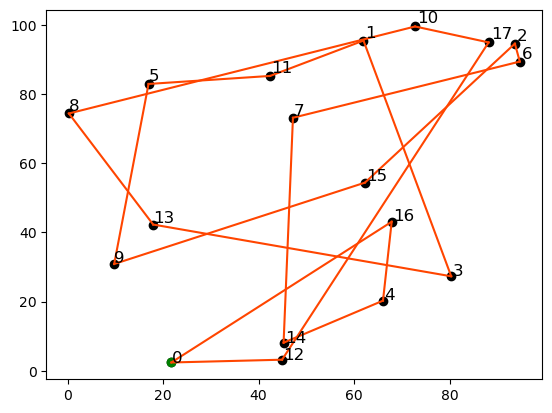

In [122]:
for i in g.edges:
    g.add_edge(i[0],i[1],weight = weighted_edges[i])

g_christofides = nx.approximation.christofides(g)

g_christofides_edges = []
for i in range(0,len(g_christofides)-1):
    
    if g_christofides[i] > g_christofides[i+1]:
        g_christofides_edges.append((g_christofides[i+1],g_christofides[i]))

    else:
        g_christofides_edges.append((g_christofides[i],g_christofides[i+1]))

christofides_distance = sum(distance_edges[i] for i in g_christofides_edges)

g_sa = nx.approximation.simulated_annealing_tsp(g, nx.approximation.greedy_tsp(g))

g_sa_edges = []
for i in range(0,len(g_sa)-1):
    
    if g_sa[i] > g_sa[i+1]:
        g_sa_edges.append((g_sa[i+1],g_sa[i]))

    else:
        g_sa_edges.append((g_sa[i],g_sa[i+1]))

sa_distance = sum(distance_edges[i] for i in g_sa_edges)

max_weight = max(list(weighted_edges.values()))
min_weight = min(list(weighted_edges.values()))
total_distance = sum(distance_edges[i] for i in paths[0])

print("total distance traveled: " + str(total_distance))
print("Christofides algorithm distance traveled: " + str(christofides_distance))
print("Simulated Annealing algorithm distance traveled: " + str(sa_distance))
print("min pheremone: " + str(min_weight))
print("max pheremone: " + str(max_weight))

x =[]
for i in coords.values():
    x.append(i[0])


y =[]
for i in coords.values():
    y.append(i[1])

plt.scatter(x,y, color='black')
plt.scatter(coords[origin][0],coords[origin][1], color='green')

for i in range(0,len(x)):
    plt.text(x[i] * (1 + 0.005), y[i] * (1 + 0.01) , i, fontsize=12)


for i in paths[0]:
    plt.plot([coords[i[0]][0],coords[i[1]][0]], [coords[i[0]][1], coords[i[1]][1]], color='orangered')

# for i in g_christofides_edges:
#     plt.plot([coords[i[0]][0],coords[i[1]][0]], [coords[i[0]][1], coords[i[1]][1]], color='c')

# for i in g_sa_edges:
#     plt.plot([coords[i[0]][0],coords[i[1]][0]], [coords[i[0]][1], coords[i[1]][1]], color='r')

display(N)
display(M)
display(U)